In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read BTC data from files
btc_hourly = pd.read_csv("./datasets/crypto/hourly/BTC.csv")
btc_4hourly = pd.read_csv("./datasets/crypto/4hourly/BTC.csv")
btc_daily = pd.read_csv("./datasets/crypto/daily/BTC.csv")
btc_weekly = pd.read_csv("./datasets/crypto/weekly/BTC.csv")

# Read ETH data from files
eth_hourly = pd.read_csv("./datasets/crypto/hourly/ETH.csv")
eth_4hourly = pd.read_csv("./datasets/crypto/4hourly/ETH.csv")
eth_daily = pd.read_csv("./datasets/crypto/daily/ETH.csv")
eth_weekly = pd.read_csv("./datasets/crypto/weekly/ETH.csv")

# Read AAPL data from files
aapl_hourly = pd.read_csv("./datasets/stocks/hourly/AAPL.csv")
aapl_4hourly = pd.read_csv("./datasets/stocks/4hourly/AAPL.csv")
aapl_daily = pd.read_csv("./datasets/stocks/daily/AAPL.csv")
aapl_weekly = pd.read_csv("./datasets/stocks/weekly/AAPL.csv")

# Read TSLA data from files
tsla_hourly = pd.read_csv("./datasets/stocks/hourly/TSLA.csv")
tsla_4hourly = pd.read_csv("./datasets/stocks/4hourly/TSLA.csv")
tsla_daily = pd.read_csv("./datasets/stocks/daily/TSLA.csv")
tsla_weekly = pd.read_csv("./datasets/stocks/weekly/TSLA.csv")

# Read AMZN data from files
amzn_hourly = pd.read_csv("./datasets/stocks/hourly/AMZN.csv")
amzn_4hourly = pd.read_csv("./datasets/stocks/4hourly/AMZN.csv")
amzn_daily = pd.read_csv("./datasets/stocks/daily/AMZN.csv")
amzn_weekly = pd.read_csv("./datasets/stocks/weekly/AMZN.csv")

In [3]:
pip install ta

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import ta
import ta.trend

def add_ta_indicators(df, rsi_window=14, ma_window=50):
    df = df.copy()

    rsi = ta.momentum.RSIIndicator(close=df["close"], window=rsi_window)
    rsi_series = rsi.rsi()
    df["rsi_signal"] = rsi_series.apply(lambda x: 1 if x < 30 else (-1 if x > 70 else 0))
    df.loc[rsi_series.isna(), "rsi_signal"] = np.nan                

    macd = ta.trend.MACD(close=df["close"])
    macd_line = macd.macd()
    macd_signal_line = macd.macd_signal()
    df["macd_cross_signal"] = (macd_line > macd_signal_line).astype(float)
    df.loc[macd_line.isna() | macd_signal_line.isna(), "macd_cross_signal"] = np.nan

    ma = ta.trend.SMAIndicator(close=df["close"], window=ma_window)
    ma_series = ma.sma_indicator()
    df["ma_signal"] = (df["close"] > ma_series).astype(float)
    df.loc[ma_series.isna(), "ma_signal"] = np.nan

    df["actual"] = df["close"].shift(-1) - df["close"]
    df["actual"] = df["actual"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    return df

In [5]:
# Adding Indicators for BTC
btc_hourly = add_ta_indicators(btc_hourly)
btc_4hourly = add_ta_indicators(btc_4hourly)
btc_daily = add_ta_indicators(btc_daily)
btc_weekly = add_ta_indicators(btc_weekly)

# Adding Indicators for ETH
eth_hourly = add_ta_indicators(eth_hourly)
eth_4hourly = add_ta_indicators(eth_4hourly)
eth_daily = add_ta_indicators(eth_daily)
eth_weekly = add_ta_indicators(eth_weekly)

# Adding Indicators for AAPL
aapl_hourly = add_ta_indicators(aapl_daily)
aapl_4hourly = add_ta_indicators(aapl_4hourly)
aapl_daily = add_ta_indicators(aapl_daily)
aapl_weekly = add_ta_indicators(aapl_weekly)

# Adding Indicators for TSLA
tsla_hourly = add_ta_indicators(tsla_hourly)
tsla_4hourly = add_ta_indicators(tsla_4hourly)
tsla_daily = add_ta_indicators(tsla_daily)
tsla_weekly = add_ta_indicators(tsla_weekly)

# Adding Indicators for AMZN
amzn_hourly = add_ta_indicators(amzn_hourly)
amzn_4hourly = add_ta_indicators(amzn_4hourly)
amzn_daily = add_ta_indicators(amzn_daily)
amzn_weekly = add_ta_indicators(amzn_weekly)

In [32]:
def plot_rsi_accuracy_bar(df_list, labels, assetName):
    accuracies = []

    for df in df_list:
        rsi_valid = df[df["rsi_signal"].isin([1, -1])].copy()
        rsi_valid["rsi_correct"] = (rsi_valid["rsi_signal"] == rsi_valid["actual"]).astype(int)
        accuracy = rsi_valid["rsi_correct"].mean()
        print(accuracy)
        accuracies.append(accuracy)

    plt.figure(figsize=(8, 5))
    plt.bar(labels, accuracies, color='skyblue')
    plt.ylim(0, 1)
    plt.axhline(0.5, color='gray', linestyle='--', label="50% Baseline")
    plt.ylabel("RSI Accuracy (%)")
    plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])
    plt.title(f"RSI Accuracy Across Timeframes for {assetName}")
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_macd_accuracy_bar(df_list, labels, assetName):
    accuracies = []

    for df in df_list:
        actual_binary = (df["close"].shift(-1) > df["close"]).astype(int)
        df_valid = df.copy()
        df_valid["macd_correct"] = (df_valid["macd_cross_signal"] == actual_binary).astype(int)

        accuracy = df_valid["macd_correct"].mean()
        print(accuracy)
        accuracies.append(accuracy)

    plt.figure(figsize=(8, 5))
    plt.bar(labels, accuracies, color='salmon')
    plt.ylim(0, 1)
    plt.axhline(0.5, color='gray', linestyle='--', label="50% Baseline")
    plt.ylabel("MACD Accuracy (%)")
    plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])
    plt.title(f"MACD Accuracy Across Timeframes for {assetName}")
    plt.grid(axis='y')
    plt.legend()

    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.1%}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_ma_accuracy_bar(df_list, labels, assetName):
    accuracies = []

    for df in df_list:
        actual_binary = (df["close"].shift(-1) > df["close"]).astype(int)
        df_valid = df.copy()
        df_valid["ma_correct"] = (df_valid["ma_signal"] == actual_binary).astype(int)

        accuracy = df_valid["ma_correct"].mean()
        print(accuracy)
        accuracies.append(accuracy)

    plt.figure(figsize=(8, 5))
    plt.bar(labels, accuracies, color='mediumseagreen')
    plt.ylim(0, 1)
    plt.axhline(0.5, color='gray', linestyle='--', label="50% Baseline")
    plt.ylabel("MA Signal Accuracy (%)")
    plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])
    plt.title(f"MA Signal Accuracy Across Timeframes for {assetName}")
    plt.grid(axis='y')
    plt.legend()

    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.1%}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

0.534367289390201
0.5179606025492468
0.5318471337579618
0.425


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\502503373.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


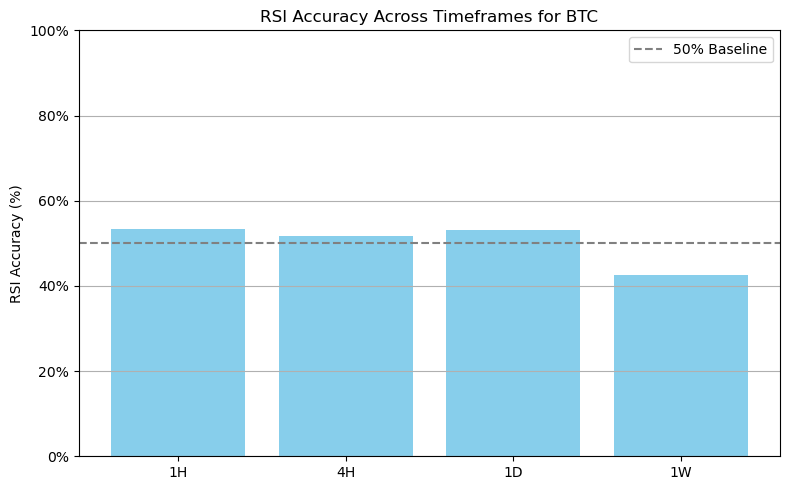

In [20]:
plot_rsi_accuracy_bar(df_list=[btc_hourly, btc_4hourly, btc_daily, btc_weekly], labels=["1H", "4H", "1D", "1W"], assetName="BTC")

0.5377375244183982
0.4941466420209489
0.5
0.4


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\502503373.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


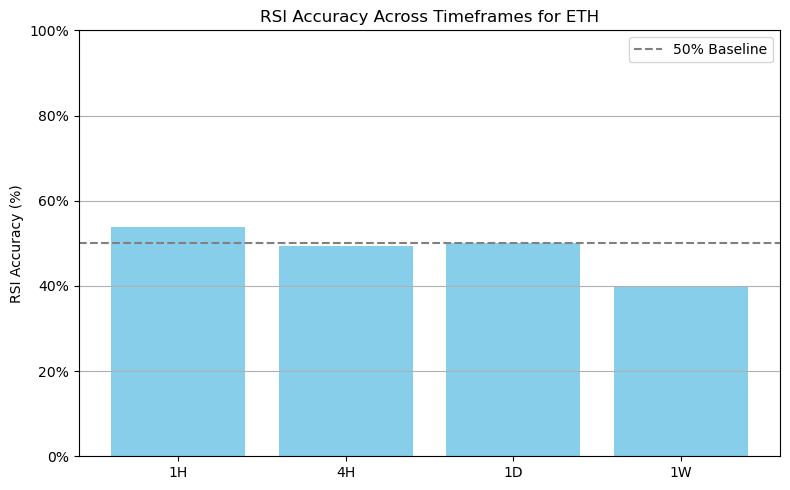

In [21]:
plot_rsi_accuracy_bar(df_list=[eth_hourly, eth_4hourly, eth_daily, eth_weekly], labels=["1H", "4H", "1D", "1W"], assetName="ETH")

0.4730290456431535
0.5159386068476978
0.4730290456431535
0.3793103448275862


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\502503373.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


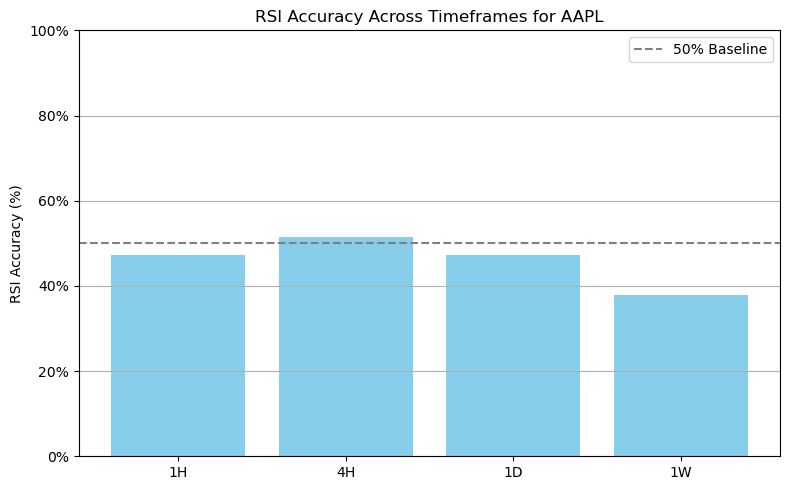

In [22]:
plot_rsi_accuracy_bar(df_list=[aapl_hourly, aapl_4hourly, aapl_daily, aapl_weekly], labels=["1H", "4H", "1D", "1W"], assetName="AAPL")

0.47966413014956705
0.48676171079429736
0.4265232974910394
0.40476190476190477


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\502503373.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


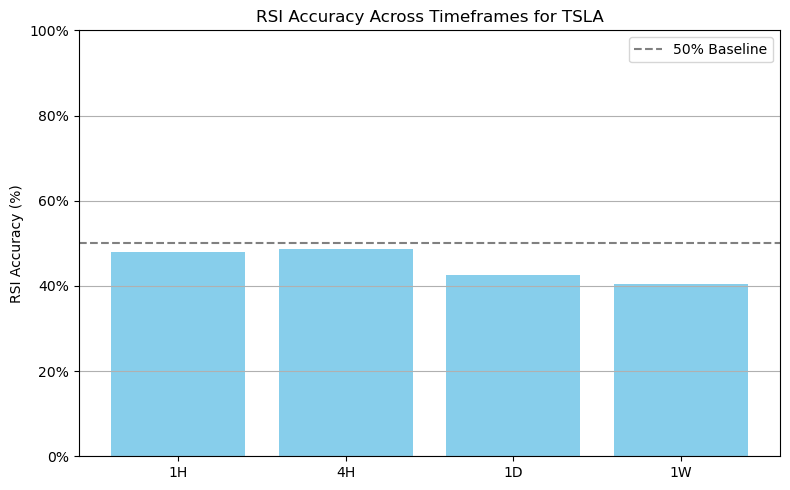

In [23]:
plot_rsi_accuracy_bar(df_list=[tsla_hourly, tsla_4hourly, tsla_daily, tsla_weekly], labels=["1H", "4H", "1D", "1W"], assetName="TSLA")

0.4769533445756043
0.48702101359703337
0.515
0.43023255813953487


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\502503373.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


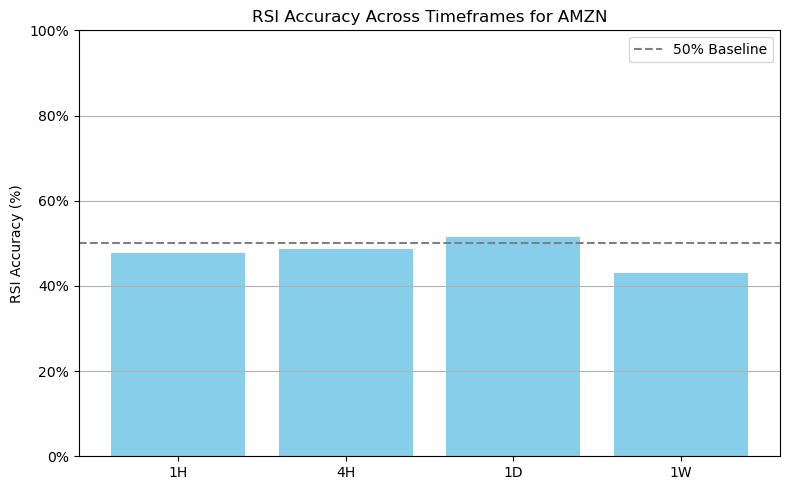

In [24]:
plot_rsi_accuracy_bar(df_list=[amzn_hourly, amzn_4hourly, amzn_daily, amzn_weekly], labels=["1H", "4H", "1D", "1W"], assetName="AMZN")

0.4795306283198352
0.48918657198192383
0.47437137330754353
0.4542372881355932


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\4022740313.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


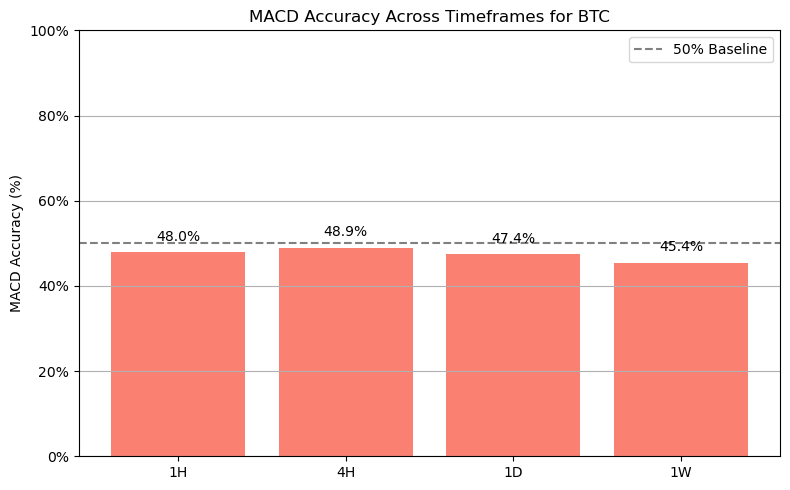

In [27]:
plot_macd_accuracy_bar(df_list=[btc_hourly, btc_4hourly, btc_daily, btc_weekly], labels=["1H", "4H", "1D", "1W"], assetName="BTC")

0.48322662735039285
0.48692704970948997
0.4874274661508704
0.4745762711864407


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\4022740313.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


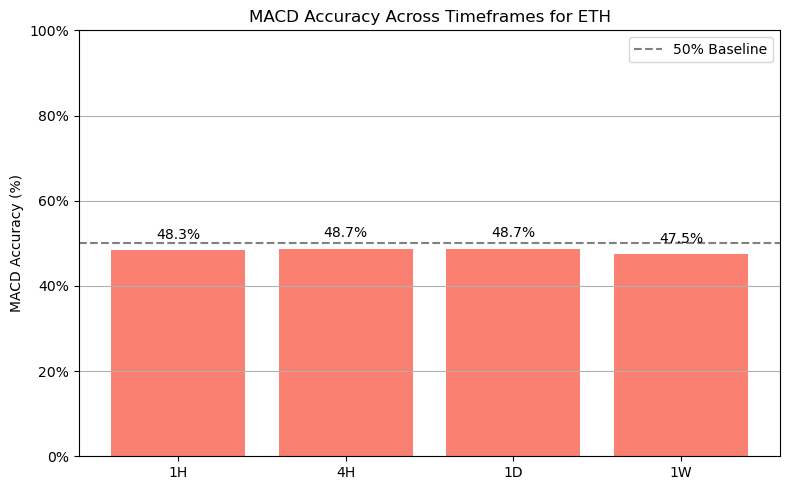

In [28]:
plot_macd_accuracy_bar(df_list=[eth_hourly, eth_4hourly, eth_daily, eth_weekly], labels=["1H", "4H", "1D", "1W"], assetName="ETH")

0.5108771929824562
0.4894773763591722
0.5108771929824562
0.5135135135135135


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\4022740313.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


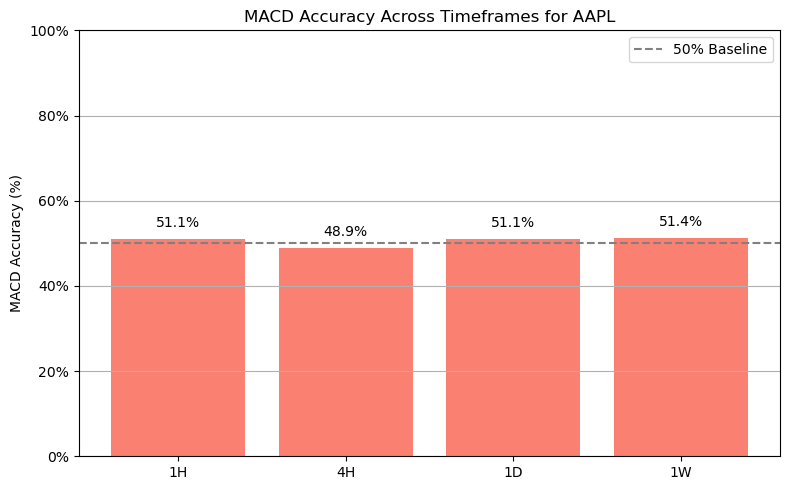

In [29]:
plot_macd_accuracy_bar(df_list=[aapl_hourly, aapl_4hourly, aapl_daily, aapl_weekly], labels=["1H", "4H", "1D", "1W"], assetName="AAPL")

0.5055391269806241
0.5012280701754386
0.5031578947368421
0.48986486486486486


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\4022740313.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


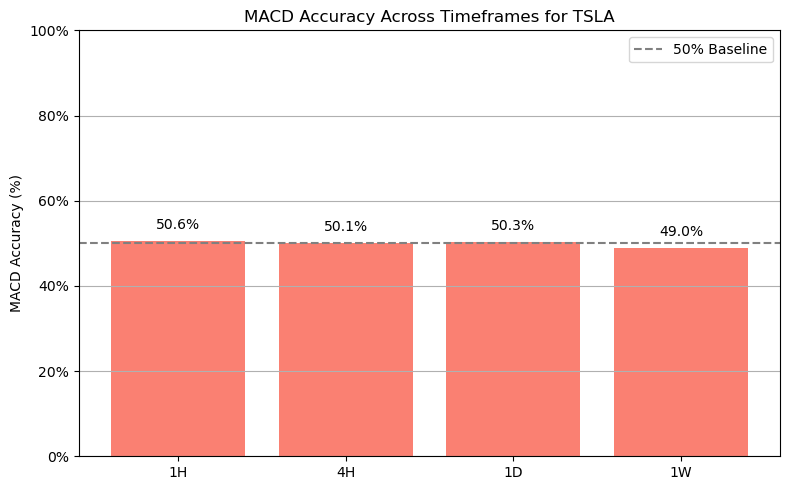

In [30]:
plot_macd_accuracy_bar(df_list=[tsla_hourly, tsla_4hourly, tsla_daily, tsla_weekly], labels=["1H", "4H", "1D", "1W"], assetName="TSLA")

0.507291329105134
0.5093942054433713
0.48
0.46959459459459457


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\4022740313.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


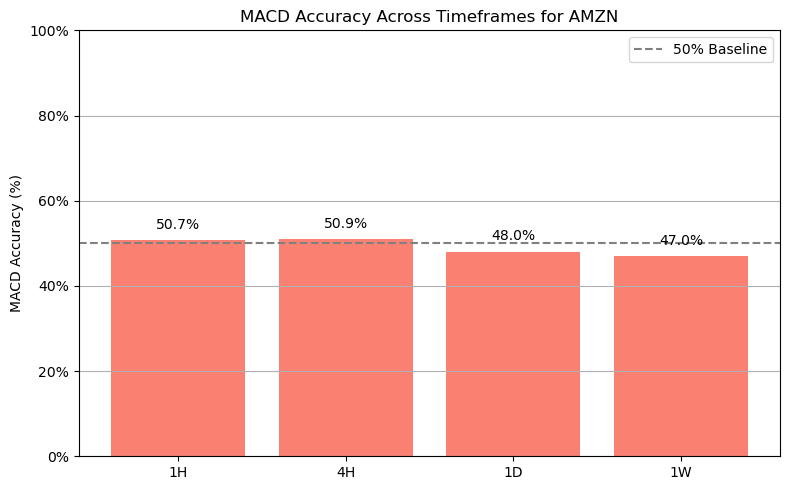

In [31]:
plot_macd_accuracy_bar(df_list=[amzn_hourly, amzn_4hourly, amzn_daily, amzn_weekly], labels=["1H", "4H", "1D", "1W"], assetName="AMZN")

0.4833276109304627
0.4918495803744351
0.4922630560928433
0.3898305084745763


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\3815030936.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


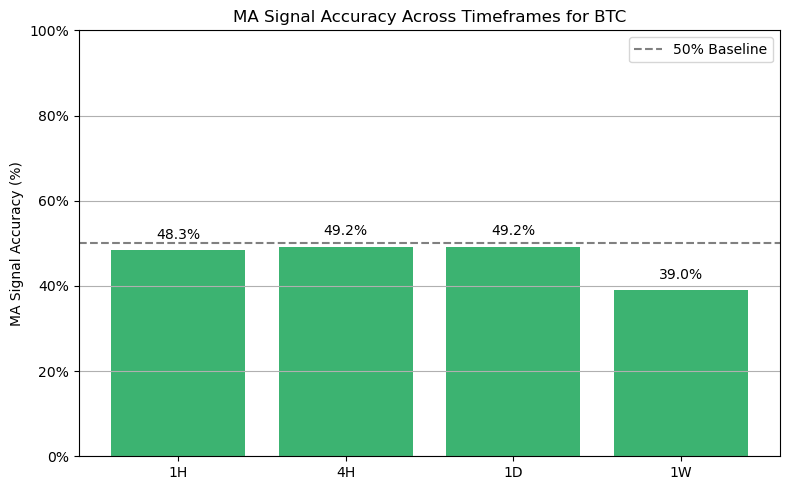

In [34]:
plot_ma_accuracy_bar(df_list=[btc_hourly, btc_4hourly, btc_daily, btc_weekly], labels=["1H", "4H", "1D", "1W"], assetName="BTC")

0.4848423646315109
0.49531956100710134
0.4961315280464217
0.4


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\3815030936.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


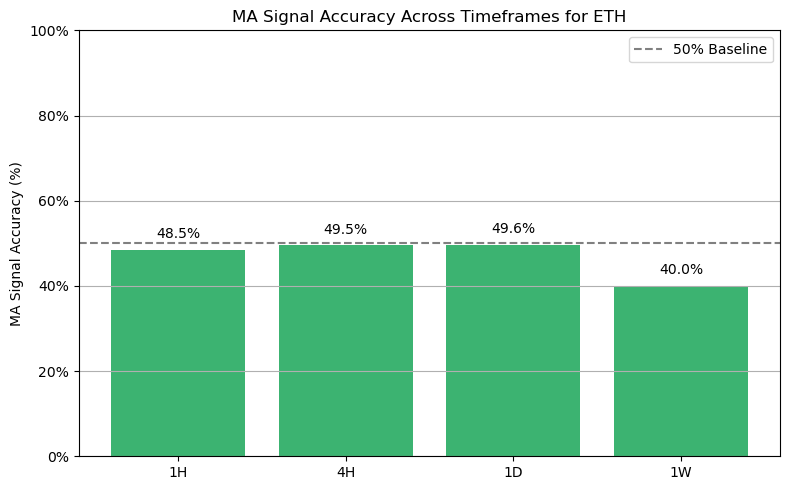

In [35]:
plot_ma_accuracy_bar(df_list=[eth_hourly, eth_4hourly, eth_daily, eth_weekly], labels=["1H", "4H", "1D", "1W"], assetName="ETH")

0.5059649122807017
0.5106980007015083
0.5059649122807017
0.42905405405405406


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\3815030936.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


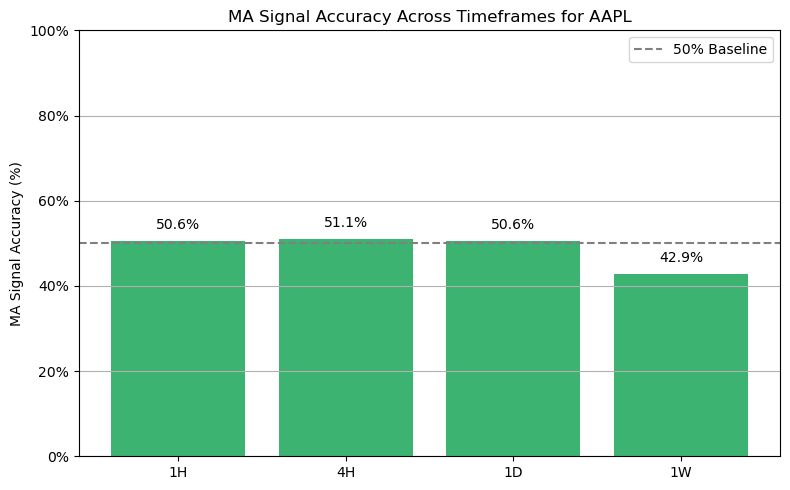

In [36]:
plot_ma_accuracy_bar(df_list=[aapl_hourly, aapl_4hourly, aapl_daily, aapl_weekly], labels=["1H", "4H", "1D", "1W"], assetName="AAPL")

0.5103941386767886
0.5126315789473684
0.5136842105263157
0.4222972972972973


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\3815030936.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


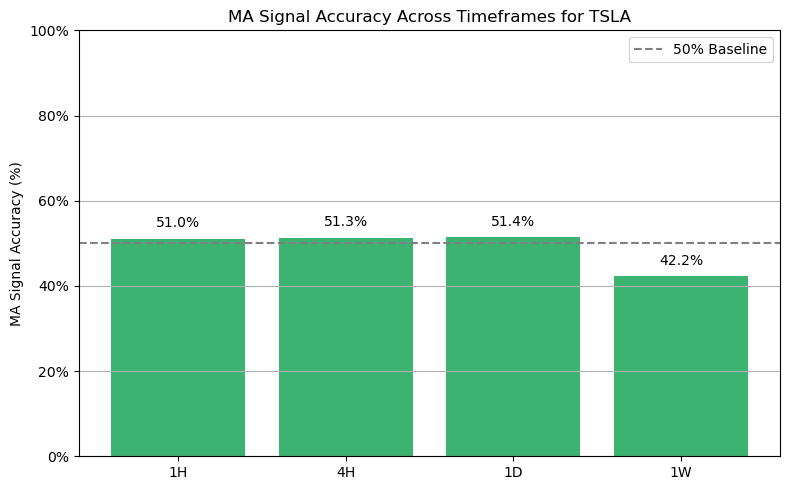

In [37]:
plot_ma_accuracy_bar(df_list=[tsla_hourly, tsla_4hourly, tsla_daily, tsla_weekly], labels=["1H", "4H", "1D", "1W"], assetName="TSLA")

0.506596916809407
0.5028972783143107
0.48
0.4358108108108108


C:\Users\anees\AppData\Local\Temp\ipykernel_58764\3815030936.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


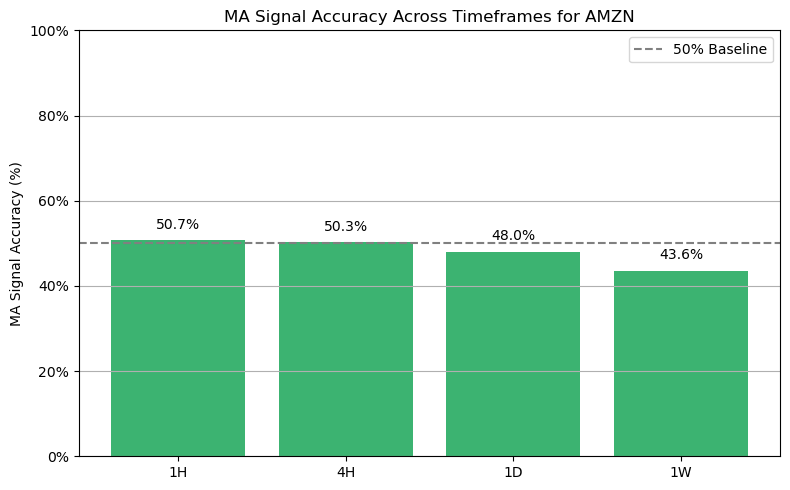

In [38]:
plot_ma_accuracy_bar(df_list=[amzn_hourly, amzn_4hourly, amzn_daily, amzn_weekly], labels=["1H", "4H", "1D", "1W"], assetName="AMZN")

In [49]:
def plot_combined_accuracy_bar(df_list, labels, assetName):
    accuracies = []

    for df in df_list:
        df = df.copy()

        # --- Convert signals to consistent format ---
        rsi = df["rsi_signal"].where(df["rsi_signal"].isin([1, -1]), np.nan)  # keep only actionable RSI
        macd = df["macd_cross_signal"].replace(0, -1)
        ma = df["ma_signal"].replace(0, -1)

        # --- Combine: majority vote ---
        combined = pd.concat([rsi, macd, ma], axis=1)
        df["combined_signal"] = combined.mean(axis=1).round().astype("Int64")

        # --- Actual movement: -1 / 0 / 1 ---
        df["actual"] = df["close"].shift(-1) - df["close"]
        df["actual"] = df["actual"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

        # --- Accuracy check only where signal is valid ---
        valid = df[df["combined_signal"].notna()]
        valid = valid[valid["combined_signal"].isin([1, -1])]
        valid["correct"] = (valid["combined_signal"] == valid["actual"]).astype(int)

        accuracy = valid["correct"].mean()
        accuracies.append(accuracy)

    # --- Plot bar chart ---
    plt.figure(figsize=(8, 5))
    plt.bar(labels, accuracies, color='orchid')
    plt.ylim(0, 1)
    plt.axhline(0.5, color='gray', linestyle='--', label="50% Baseline")
    plt.ylabel("Combined Signal Accuracy (%)")
    plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])
    plt.title(f"Combined Indicator Accuracy Across Timeframes for {assetName}")
    plt.grid(axis='y')
    plt.legend()

    # Add values on top of bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.1%}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

C:\Users\anees\AppData\Local\Temp\ipykernel_58764\862432980.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


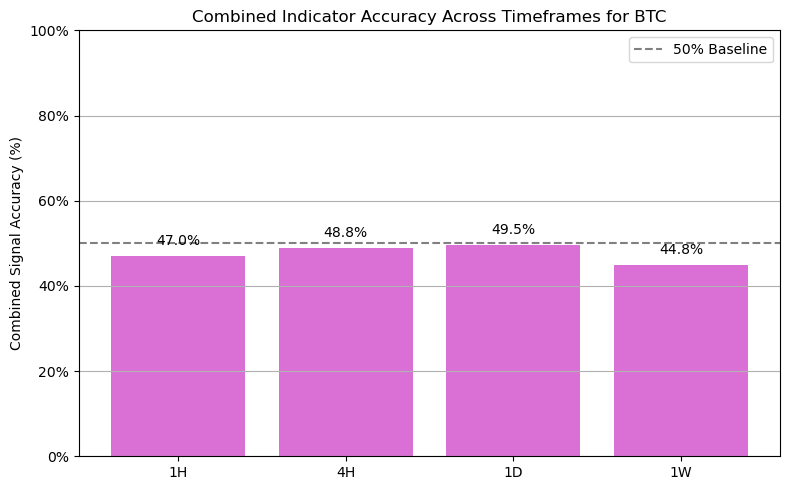

In [51]:
plot_combined_accuracy_bar(df_list=[btc_hourly, btc_4hourly, btc_daily, btc_weekly], labels=["1H", "4H", "1D", "1W"], assetName="BTC")

C:\Users\anees\AppData\Local\Temp\ipykernel_58764\862432980.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


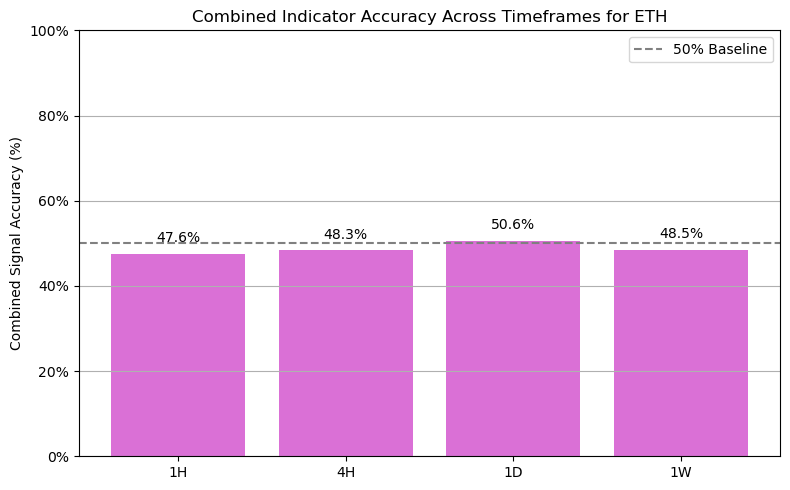

In [52]:
plot_combined_accuracy_bar(df_list=[eth_hourly, eth_4hourly, eth_daily, eth_weekly], labels=["1H", "4H", "1D", "1W"], assetName="ETH")

C:\Users\anees\AppData\Local\Temp\ipykernel_58764\862432980.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


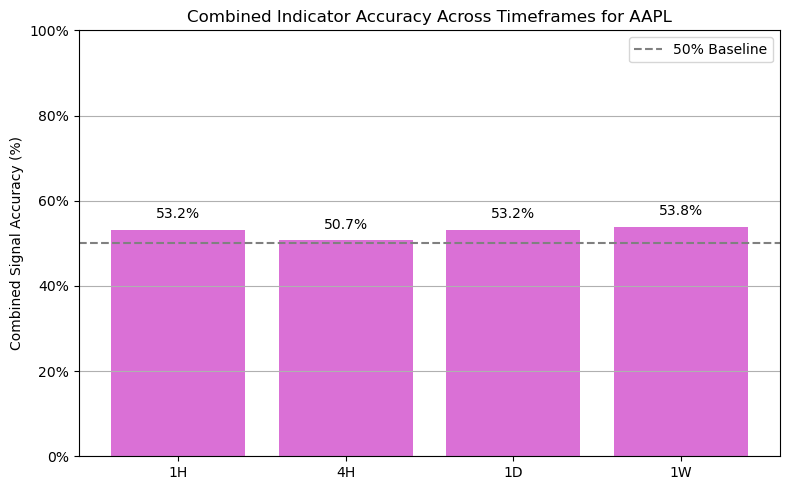

In [53]:
plot_combined_accuracy_bar(df_list=[aapl_hourly, aapl_4hourly, aapl_daily, aapl_weekly], labels=["1H", "4H", "1D", "1W"], assetName="AAPL")

C:\Users\anees\AppData\Local\Temp\ipykernel_58764\862432980.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


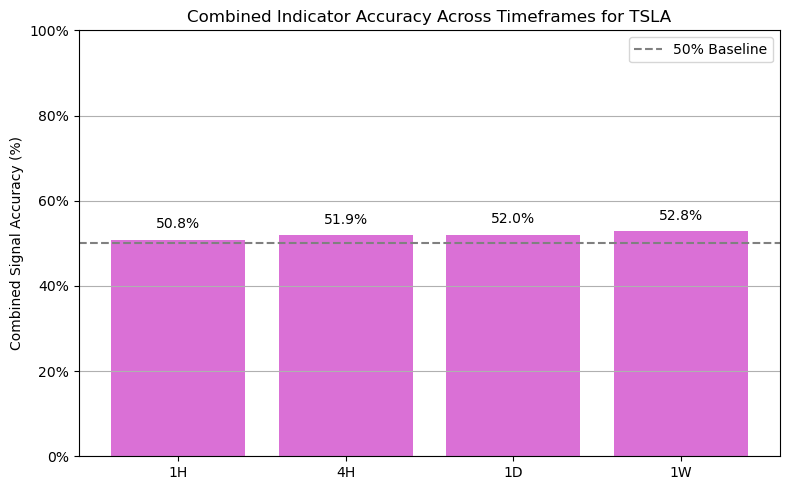

In [54]:
plot_combined_accuracy_bar(df_list=[tsla_hourly, tsla_4hourly, tsla_daily, tsla_weekly], labels=["1H", "4H", "1D", "1W"], assetName="TSLA")

C:\Users\anees\AppData\Local\Temp\ipykernel_58764\862432980.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0%}'.format(y) for y in plt.gca().get_yticks()])


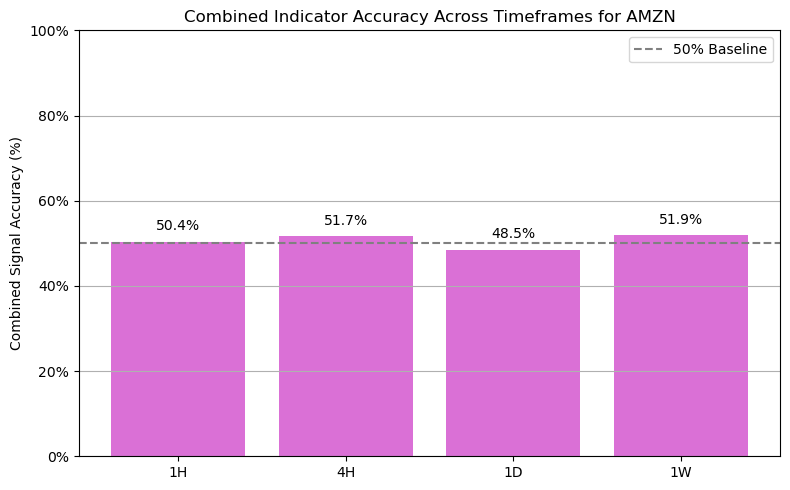

In [55]:
plot_combined_accuracy_bar(df_list=[amzn_hourly, amzn_4hourly, amzn_daily, amzn_weekly], labels=["1H", "4H", "1D", "1W"], assetName="AMZN")